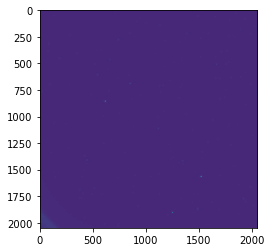

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
sci=fits.open('sci_total/reduced/SZ_Lyn-0002_R.fit')[0]
plt.imshow(sci.data)






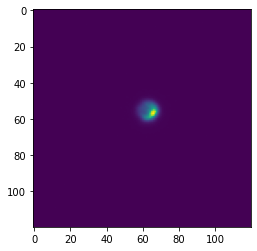

In [4]:
reg=np.s_[800:920,550:670]
reg
sub_img=sci.data[reg]
plt.imshow(sub_img)

In [15]:
np.argmax(sub_img)
ymax, xmax=np.unravel_index(np.argmax(sub_img), sub_img.shape)
rows, cols=np.ogrid[-ymax:sub_img.shape[0]-ymax, -xmax:sub_img.shape[0]-xmax]
mask=np.logical_and((np.abs(rows))**2 + (np.abs(cols))**2 < 900.0/np.pi, 3<4)
mask
#per cambiare il raggio è meglio andare a modificare 900, ovvero il numero totale di pixel all'interno del cerchio (circa)


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

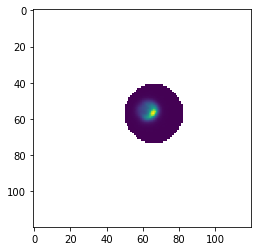

In [16]:
inside=np.copy(sub_img)
inside[~mask]=np.nan
plt.imshow(inside)

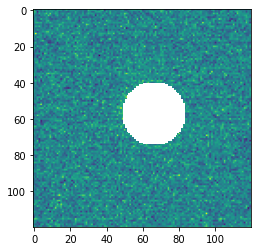

In [17]:
outside=np.copy(sub_img)
outside[mask]=np.nan
plt.imshow(outside)

(array([  1.,   0.,   1.,   1.,   0.,   0.,   1.,   3.,   0.,   4.,   4.,
          7.,   6.,   9.,  10.,  13.,  18.,  15.,  25.,  39.,  38.,  44.,
         53.,  75.,  78.,  79., 106., 126., 160., 143., 193., 220., 249.,
        276., 278., 297., 341., 376., 382., 363., 391., 426., 407., 404.,
        431., 457., 488., 465., 456., 411., 440., 427., 385., 360., 349.,
        333., 288., 288., 224., 229., 222., 200., 185., 147., 127., 104.,
        107.,  82.,  64.,  52.,  58.,  56.,  35.,  34.,  23.,  19.,  21.,
         16.,  11.,  14.,  10.,   7.,   4.,   0.,   2.,   2.,   2.,   2.,
          1.,   2.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.]),
 array([32775.90379399, 32777.15566384, 32778.40753368, 32779.65940353,
        32780.91127337, 32782.16314322, 32783.41501307, 32784.66688291,
        32785.91875276, 32787.1706226 , 32788.42249245, 32789.6743623 ,
        32790.92623214, 32792.17810199, 32793.42997183, 32794.68184168,
        32795.93371153, 32797.

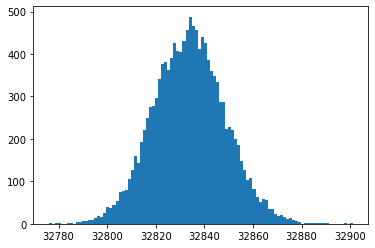

In [75]:
plt.hist(np.ravel(outside[np.logical_not(np.isnan(outside))]), bins=100)

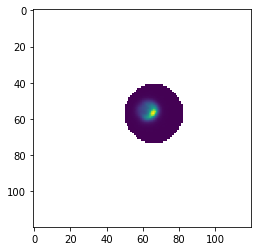

In [18]:
bkg=np.nanmean(outside)
bkg_noise=np.nanstd(outside)
bkg_noise
gain=sci.header['EGAIN']
bkg=bkg*gain
bkg_noise=bkg_noise*gain
inside_bkgsub=inside*gain-bkg
plt.imshow(inside_bkgsub)

In [33]:
flux=inside_bkgsub
bkg_subfact=np.sum(mask)/np.sum(~mask)
flux_total=np.nansum(flux)

ron = 28.8
ron_subfact = np.sum(mask)/(500*500*7)
error = np.sqrt(flux_total + (np.sum(mask)+ron_subfact)*ron**2  + (np.sum(mask)+bkg_subfact)*bkg_noise**2)

snr_total=flux_total/error
snr_total


705.4899335437285

In [13]:
class Star():
    
    def __init__(self, img, reg):
        """ @brief Initialize a star from a (reduced) image
            @param img Image
            @param reg Region to define the subimage
        """
        
        self.img = img
        self.reg = reg
        
        self.sub_img = img[reg]
        shape = self.sub_img.shape
        self.yc, self.xc = np.unravel_index(np.argmax(self.sub_img), self.sub_img.shape)
        self.rows, self.cols = np.ogrid[-self.yc:shape[0]-self.yc, -self.xc:shape[1]-self.xc]
 

    def _sub_img_mask_square(self, thr):
        """ @brief Create a square mask on the subimage
        """
        
        self.mask = np.logical_and(np.abs(self.rows)<thr, np.abs(self.cols)<thr)        
        self.inside = np.copy(self.sub_img)
        self.outside = np.copy(self.sub_img)
        self.inside[~self.mask] = np.nan
        self.outside[self.mask] = np.nan
        self.npix = np.sum(~np.isnan(self.inside))
        self.ron_subfact = np.sum(self.mask)/(500*500*7)
        self.bkg_subfact = np.sum(self.mask)/np.sum(~self.mask)
    
    def _sub_img_mask_circle(self, pix):
        
        self.mask = np.logical_and((np.abs(self.rows))**2 + (np.abs(self.cols))**2 < pix/np.pi, 3<4)
        self.inside = np.copy(self.sub_img)
        self.outside = np.copy(self.sub_img)
        self.inside[~self.mask] = np.nan
        self.outside[self.mask] = np.nan
        self.npix = np.sum(~np.isnan(self.inside))
        self.ron_subfact = np.sum(self.mask)/(500*500*7)
        self.bkg_subfact = np.sum(self.mask)/np.sum(~self.mask)
        
    def _bkg_subtract(self, gain):
        """ @brief Subtract the background
            @param gain Gain
        """
        
        outside_mean = np.nanmean(self.outside)
        outside_std = np.nanstd(self.outside)
        self.inside_bkgsub = self.inside-outside_mean
        self.bkg = outside_mean*gain
        self.bkg_noise = outside_std*gain

        
    def _flux_err_compute(self, gain, ron):
        """ @brief Compute flux and error
            @param gain Gain
            @param ron RON
        """
        
        self.flux = np.nansum(self.inside_bkgsub)*gain
        self.error = np.sqrt(self.flux + (np.sum(self.mask)+self.ron_subfact)*ron**2 \
                             + (np.sum(self.mask)+self.bkg_subfact)*self.bkg_noise**2)
        self.snr = self.flux/self.error 
        
    def photometry_square(self, thr=15, gain=0.82, ron=28.8):
            """ @brief Perform photometry on a subimage using a square mask 
                @param Threshold (half-side) of square mask
                @param gain Gain
                @param ron RON
            """

            self._sub_img_mask_square(thr)
            self._bkg_subtract(gain)
            self._flux_err_compute(gain, ron)

        
    def photometry_circle(self, pix=900, gain=0.82, ron=28.8):
        """ @brief Perform photometry on a subimage using a square mask 
            @param Threshold (half-side) of square mask
            @param gain Gain
            @param ron RON
        """

        self._sub_img_mask_circle(pix)
        self._bkg_subtract(gain)
        self._flux_err_compute(gain, ron)
        
    def magnitude(self, ref):
        """ @brief Compute magnitude from flux
        @param ref Reference star
        """
    
        self.mag = ref.mag - 2.5*(np.log10(self.flux)-np.log10(ref.flux))

In [10]:
sz_lyn = Star(sci.data, np.s_[800:920,550:670])
sz_lyn.photometry_circle()

bjr_415 = Star(sci.data, np.s_[630:750,770:890])
bjr_415.photometry_circle()

bjr_118= Star(sci.data, np.s_[200:350,650:800])
bjr_118.photometry_circle()
print("SZ Lyn  – Flux: %2.2e+/-%2.2e ph; background: %2.2e ph; SNR: %2.2e" 
      % (sz_lyn.flux, sz_lyn.error, sz_lyn.bkg, sz_lyn.snr))
print("BJR_415 – Flux: %2.2e+/-%2.2e ph; background: %2.2e ph; SNR: %2.2e" 
      % (bjr_415.flux, bjr_415.error, bjr_415.bkg, bjr_415.snr))

bjr_415.mag = 10.481  # R
bjr_118.mag = 
sz_lyn.magnitude(bjr_415)


print("SZ Lyn  - Magnitude: %2.3f" % sz_lyn.mag)

SyntaxError: invalid syntax (<ipython-input-10-b84b52d4ab27>, line 15)

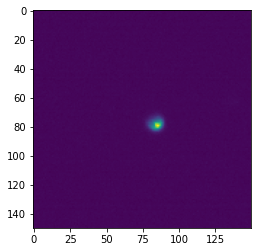

In [39]:
reg=np.s_[200:350,650:800]
reg
sub_img=sci.data[reg]
plt.imshow(sub_img)

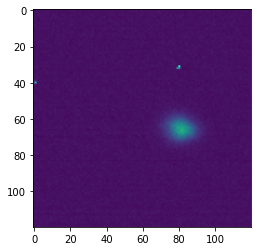

In [36]:
sci1=fits.open('sci_total/reduced/SZ_Lyn-0023_R.fit')[0]
reg=np.s_[215:335, 665:785]
reg
sub_img=sci1.data[reg]
plt.imshow(sub_img)

In [34]:
sz_lyn=Star(sci1.data, np.s_[750:870,500:620])
sz_lyn.photometry_circle()

bjr_415 = Star(sci1.data, np.s_[580:700,720:840])
bjr_415.photometry_circle()

bjr_118= Star(sci1.data, np.s_[150:300,600:750])
bjr_118.photometry_circle()

print("SZ Lyn  – Flux: %2.2e+/-%2.2e ph; background: %2.2e ph; SNR: %2.2e" 
      % (sz_lyn.flux, sz_lyn.error, sz_lyn.bkg, sz_lyn.snr))
print("BJR_415 – Flux: %2.2e+/-%2.2e ph; background: %2.2e ph; SNR: %2.2e" 
      % (bjr_415.flux, bjr_415.error, bjr_415.bkg, bjr_415.snr))


bjr_415.mag = 10.481  # R
bjr_118.mag = 11.367
sz_lyn.magnitude(bjr_118)


print("SZ Lyn  - Magnitude: %2.3f" % sz_lyn.mag)

SZ Lyn  – Flux: 1.22e+05+/-7.08e+02 ph; background: 2.69e+04 ph; SNR: 1.73e+02
BJR_415 – Flux: 3.45e+03+/-9.31e+02 ph; background: 2.69e+04 ph; SNR: 3.71e+00
SZ Lyn  - Magnitude: 5.758
